# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import time
from itertools import count
%matplotlib inline

from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name='Tennis_Windows_x86_64/Tennis.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
brain_name

'TennisBrain'

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [6]:
agent=Agent(state_size=state_size, action_size=action_size, random_seed=2,num_agents=num_agents)
agent_object = [Agent(state_size=state_size, action_size=action_size, random_seed=2,num_agents=num_agents) for _ in range(num_agents)]

In [7]:
for idx, agent_name in enumerate(env_info.agents):
    print(idx,agent_name )
print()    
for idx, agent_name in enumerate(agent_object):
    print(idx,agent_name )

0 942
1 952

0 <ddpg_agent.Agent object at 0x00000229251EA5F8>
1 <ddpg_agent.Agent object at 0x00000229252154E0>


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [8]:
def ddpg(n_episodes=5000, max_t=1000,print_every=100,window_size=100):
    scores_deque = deque(maxlen=window_size) # last 100 scores
    scores_list = []
    average_score_list = []
    excess_episode =500
    excess_average_score = 0.5
    env_solv = False
    episode_required = 0 # Go 100 more episode beyond episode when environment is solved ==n_episodes
    maximum_average_score = 0 # maximum average score including episode_required
    maximum_episode = 0 # episode at which i get maximum_average_score
    
    start_time = time.time()
    for i_episode in range(1, n_episodes+1):
        scores = np.zeros(num_agents)
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations                  # get the current state (for each agent)
        agent.reset()
        
        for ts in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            

            agent.step_and_buff(states, actions, rewards, next_states, dones,ts)
            states  = next_states
            scores += rewards                                  # update the score (for each agent)
            if np.any(dones):                                  # exit loop if episode finished
                break
                
        score = np.max(scores)        
        scores_list.append(score)
        scores_deque.append(score)

        average_score = np.average(scores_deque)
        average_score_list.append(average_score)   
            
        print("\rEpisode: {:4d}   Episode Score: {:.2f}   Average Score: {:.4f}".format(i_episode,score,average_score), end="")
        if i_episode >= 100:
            if not env_solv:
                if average_score >= 0.5:
                    end_time = time.time()
                    print("........Environment solved", "in  time {:.2f}".format( end_time-start_time))
                    episode_required = i_episode + excess_episode
                    env_solv = True
            elif maximum_average_score < average_score:
                maximum_average_score = average_score
                maximum_episode = i_episode

                
        if i_episode % print_every == 0:
            print("\rEpisode: {:4d}   Episode Score: {:.2f}   Average Score: {:.4f}".format(i_episode,score,average_score))
            for idx, agent_name in enumerate(agent_object):
                torch.save(agent_name.actor_local.state_dict(), "actor_checkpoint_" + str(idx) + ".pth")
                torch.save(agent_name.critic_local.state_dict(), "critic_checkpoint_" + str(idx) + ".pth")            
            
        if i_episode >= episode_required and average_score + excess_average_score < maximum_average_score:
                break
    print()            
    print("\n\rMaximum Average Score (over 100 episodes): {:.4f}  at Episode: {:4d}".format(maximum_average_score,maximum_episode))
    
    return scores_list,average_score_list

scores,averages = ddpg()

D:\Anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode:  100   Episode Score: 0.00   Average Score: 0.0056
Episode:  200   Episode Score: 0.00   Average Score: 0.0010
Episode:  300   Episode Score: 0.00   Average Score: 0.0000
Episode:  400   Episode Score: 0.00   Average Score: 0.0000
Episode:  500   Episode Score: 0.09   Average Score: 0.0225
Episode:  600   Episode Score: 0.20   Average Score: 0.0460
Episode:  700   Episode Score: 0.10   Average Score: 0.0867
Episode:  800   Episode Score: 0.10   Average Score: 0.1425
Episode:  900   Episode Score: 0.20   Average Score: 0.1836
Episode: 1000   Episode Score: 0.10   Average Score: 0.2382
Episode: 1077   Episode Score: 2.60   Average Score: 0.5066........Environment solved in  time 1912.06
Episode: 1100   Episode Score: 2.60   Average Score: 0.9401
Episode: 1200   Episode Score: 2.60   Average Score: 1.6532
Episode: 1300   Episode Score: 2.60   Average Score: 1.9366
Episode: 1400   Episode Score: 0.39   Average Score: 1.7060
Episode: 1500   Episode Score: 1.49   Average Score: 1.97

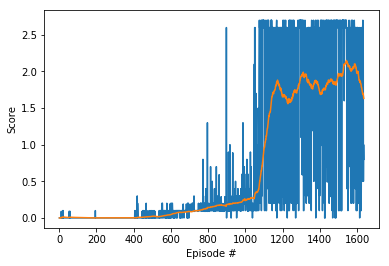

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(averages)+1), averages)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [10]:
env.close()